# Term Deposit Salse Prediction 

## Goal
Using the collected from existing customers, build a model that will help the marketing team identify  potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio

## input variables:
### bank client data:

1. age (numeric)<br>
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4. education (categorical: 'tertiary', 'secondary', 'unknown', 'primary')<br>
5. default: has credit in default? (categorical: 'no','yes')<br>
6. balance: total account balance (numeric)
7. housing: has housing loan? (categorical: 'no','yes')<br>
8. loan: has personal loan? (categorical: 'no','yes')<br>
### related with the last contact of the current campaign:<br>
9. contact: contact communication type (categorical: 'cellular','telephone','unknown')<br> 
10. day: last contact day of the month (numerical)<br>
11. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
12. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>

### other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
15. previous: number of contacts performed before this campaign and for this client (numeric)<br>
16. poutcome: outcome of the previous marketing campaign (categorical: 'failure','other','success', "unknown")<br>

### Output variable (desired target):<br>
17. Target: has the client subscribed a term deposit? (binary: 'yes','no')



In [1]:
# import all packages
from datetime import date
import glob
# import pandas_datareader as web
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the dataset 
df = pd.read_csv("bank-full.csv")

### Data Preprocessing and Visualization 

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.shape # 45211 records we have 

(45211, 17)

In [5]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'Target'],
      dtype='object')

### Check Missing Data 

In [6]:
def missing_data(df):
    """
    Objective
    ----------
    it shows the missing data in each column with 
    total missing values, percentage of missing value and
    its data type in descending order.
    
    parameters
    ----------
    df: pandas dataframe
        input data frame 
    
    returns
    ----------
    missing_data: output data frame(pandas dataframe)
    
    """
    
    total = df.isnull().sum().sort_values(ascending=False)
    percent = round((df.isnull().sum()/df.isnull().count()  * 100).sort_values(ascending=False),2)
    data_type = df.dtypes
    missing_data = pd.concat([total,percent,data_type],axis=1,keys=['Total','Percent','Data_Type']).sort_values("Total", axis = 0, ascending = False)
    
    return missing_data

In [7]:
missing_data(df) # missing data for train

,Total,Percent,Data_Type
age,0,0.0,int64
job,0,0.0,object
marital,0,0.0,object
education,0,0.0,object
default,0,0.0,object
balance,0,0.0,int64
housing,0,0.0,object
loan,0,0.0,object
contact,0,0.0,object
day,0,0.0,int64


No missing values present in this data

In [12]:
def drop_duplicates(df):
    """
    Objective
    ----------
    Drop duplicates rows in data frame except for the first occurrence.
    
    parameters
    ----------
    df: pandas dataframe
        input data frame 
        
    returns
    ----------
    dataframe with all unique rows
    """
    
        
    try:
        dr = df.duplicated().value_counts()[1]
        print("[INFO] Dropping {} duplicates records...".format(dr))
        f_df = df.drop_duplicates(keep="first")
        
        return f_df
    except KeyError:
        print("[INFO] No duplicates records found")
        return df

In [13]:
df = drop_duplicates(df)

[INFO] No duplicates records found


In [14]:
#Describe
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Check Unique values of all the column

In [15]:
for i in df.columns:
    
    print(i)
    print(df[i].unique())
    print('---'*20)

age
[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
------------------------------------------------------------
job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
------------------------------------------------------------
marital
['married' 'single' 'divorced']
------------------------------------------------------------
education
['tertiary' 'secondary' 'unknown' 'primary']
------------------------------------------------------------
default
['no' 'yes']
------------------------------------------------------------
balance
[ 2143    29     2 ...  8205 14204 16353]
------------------------------------------------------------
housing
['yes' 'no']
-----------------------------------------------------

### List of numeric columns

In [16]:
### numerical 
numerical_cols = list(df.select_dtypes(exclude=['object']))
numerical_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

### List of Categorical columns

In [17]:
### categorical
category_cols = list(df.select_dtypes(include=['object']))
category_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'Target']

In [18]:
df['Target'].value_counts()

no     39922
yes     5289
Name: Target, dtype: int64

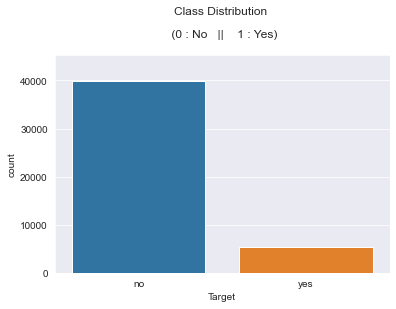

In [19]:
ax = sns.countplot(x="Target", data=df)
plt.ylim(0, df.shape[0])
plt.title('Class Distribution \n\n (0 : No   ||    1 : Yes)\n')
print()

In [20]:
No = round(df["Target"].value_counts()[1]/len(df) * 100, 2)
yes = round(df["Target"].value_counts()[0]/len(df) * 100, 2)

print("Subscribe for term deposit : {} % of the dataset".format(No))
print("Does Not Subscribe for term deposit: {} % of the dataset".format(yes))

Subscribe for term deposit : 11.7 % of the dataset
Does Not Subscribe for term deposit: 88.3 % of the dataset


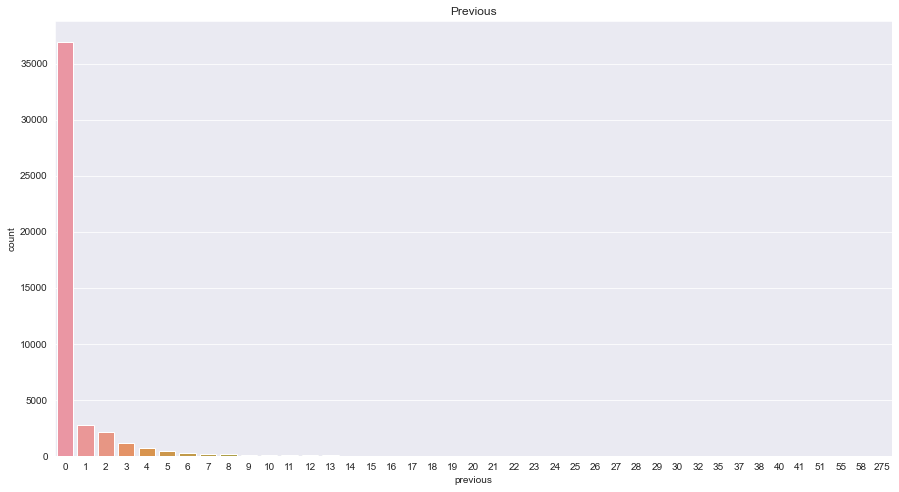

In [21]:
plt.figure(figsize=(15,8))
sns.countplot(x = "previous", data= df)
plt.title("Previous")
plt.show()

The purpose of this attribute is to find number of contacts performed before this campaign and for this clients. Here we can see that value of zero is more i.e the employee which is never contacted before is more.  


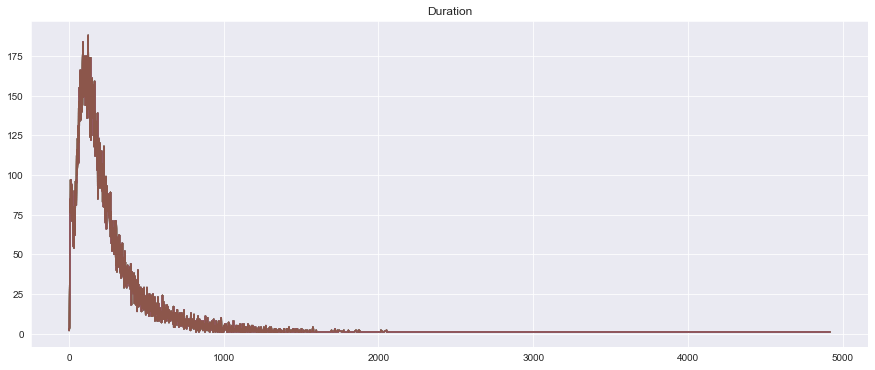

In [22]:
plt.figure(figsize=(15,6))
plt.plot(df.groupby(["duration"]).count())
plt.title("Duration")
plt.show()

This input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. We see that the duration is high at initial and it is right skewed data

### JOB 

Text(0.5, 1.0, 'Job Type')

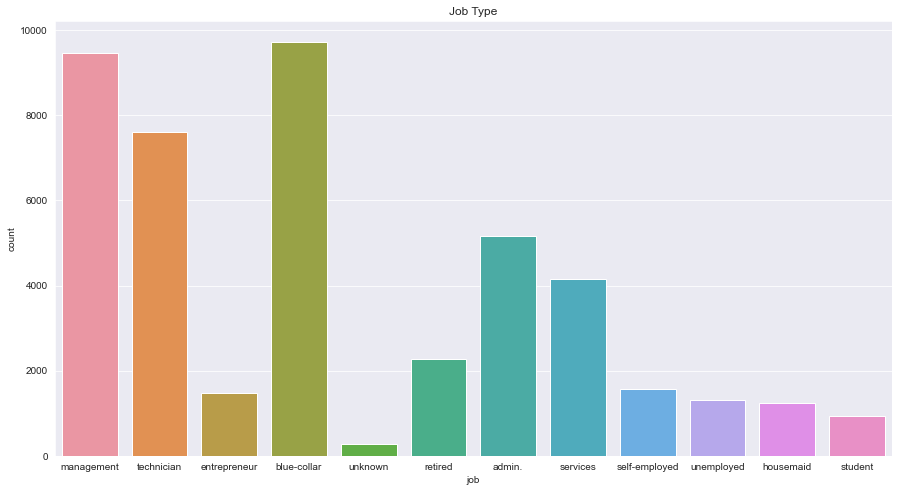

In [23]:
plt.figure(figsize=(15,8))
sns.countplot(x="job", data=df)
plt.title("Job Type")

Text(0.5, 1.0, 'Job type for both category')

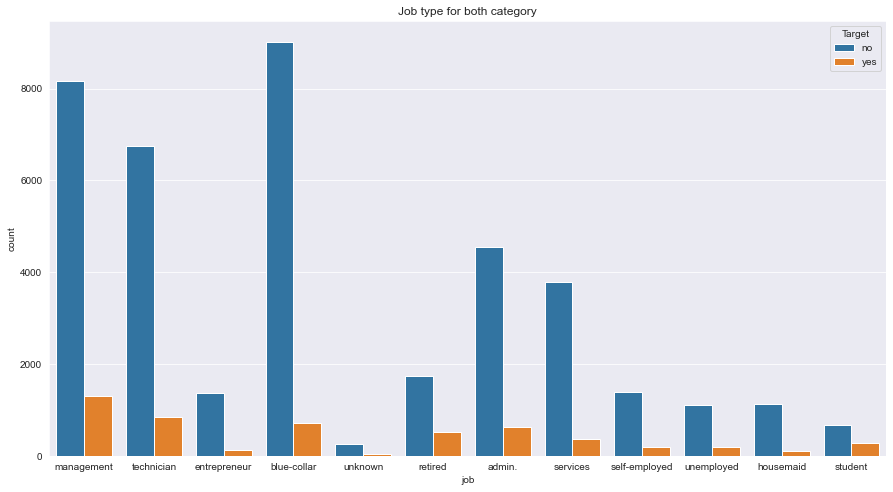

In [24]:
plt.figure(figsize=(15,8))
sns.countplot(x="job", hue="Target", data=df)
plt.title("Job type for both category")

This is categorical type variable which shows that type of job doing by employee. Here blue-collar technician and management has more number as compare to others.
and most subscription for term deposit is from these job types only and admin also

### Martial

Text(0.5, 1.0, 'Marital Status')

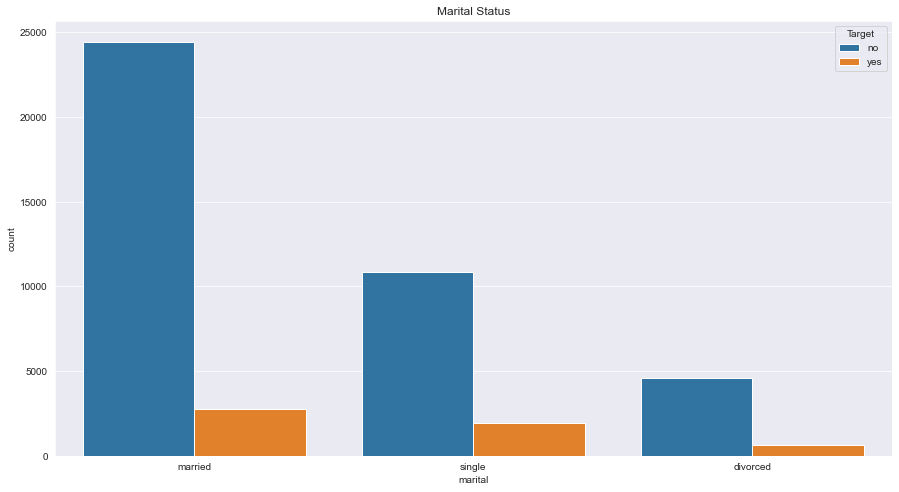

In [25]:
plt.figure(figsize=(15,8))
sns.countplot(x='marital',hue="Target", data=df)
plt.title("Marital Status")

Text(0.5, 1.0, 'education')

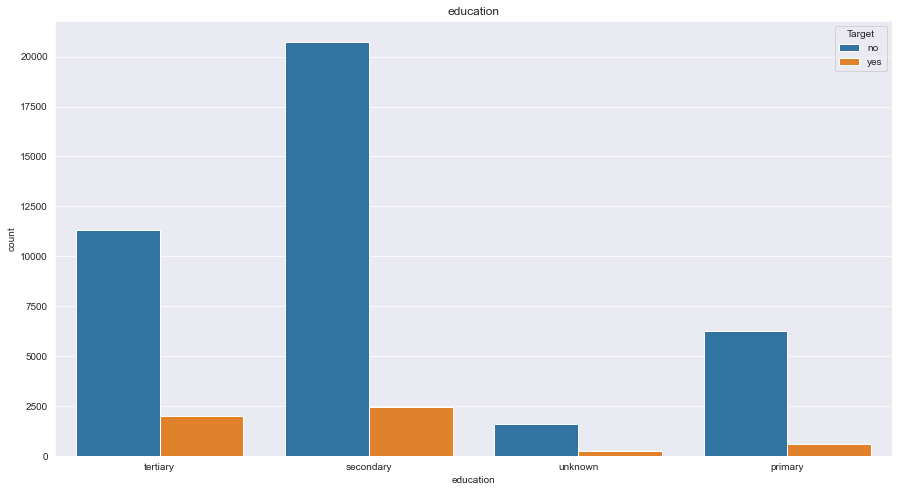

In [26]:
plt.figure(figsize=(15,8))
sns.countplot(x='education',hue="Target", data=df)
plt.title("education")

majority client who subscribe for term deposit  belong to teritary or secondary education 

Text(0.5, 1.0, 'poutcome')

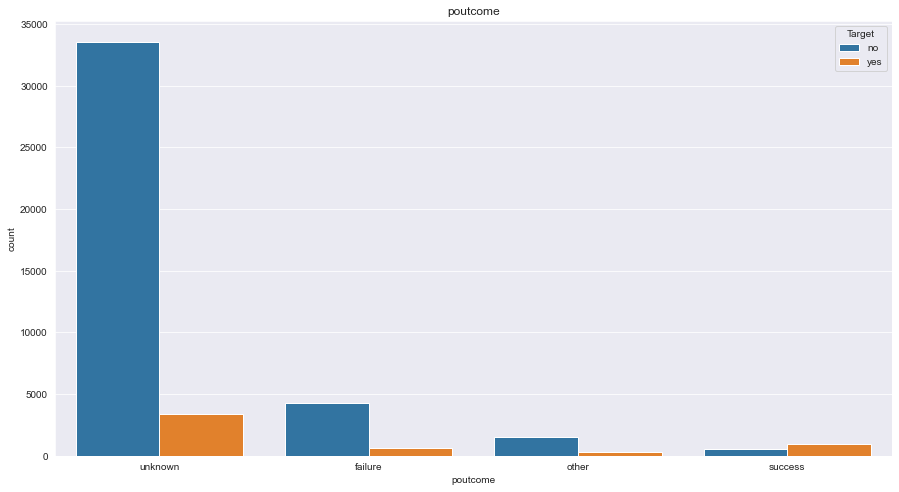

In [27]:
plt.figure(figsize=(15,8))
sns.countplot(x='poutcome',hue="Target", data=df)
plt.title("poutcome")

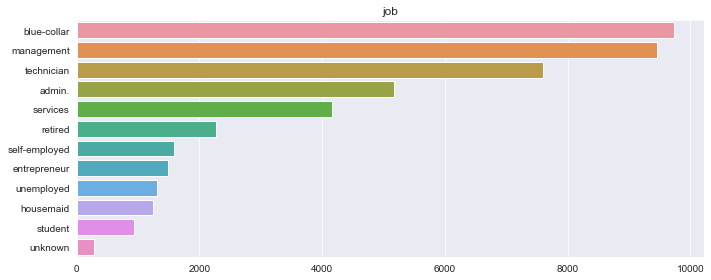

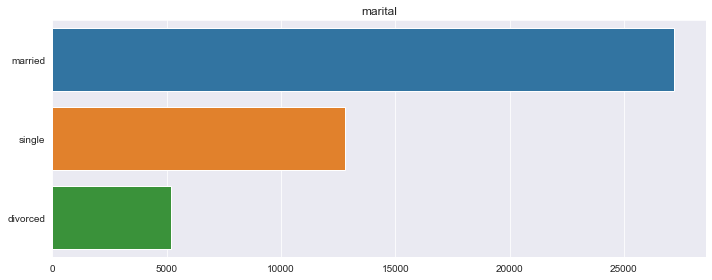

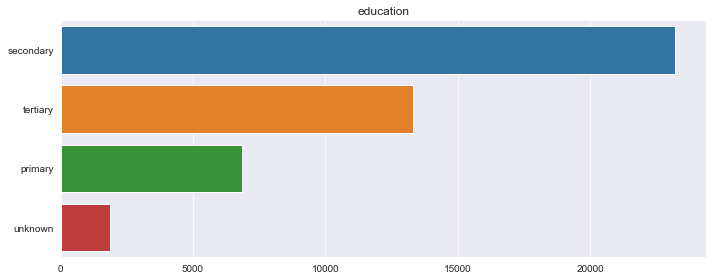

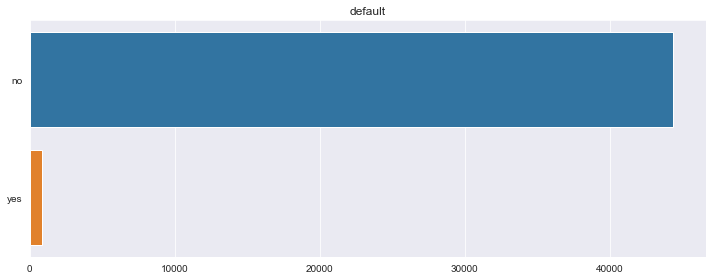

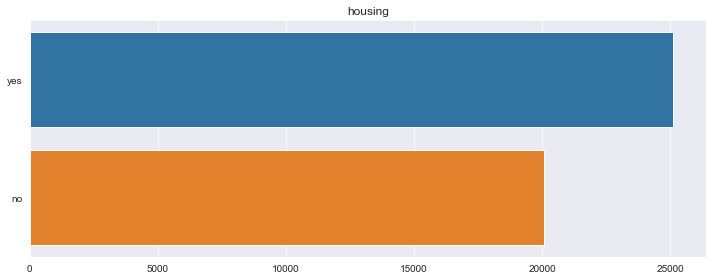

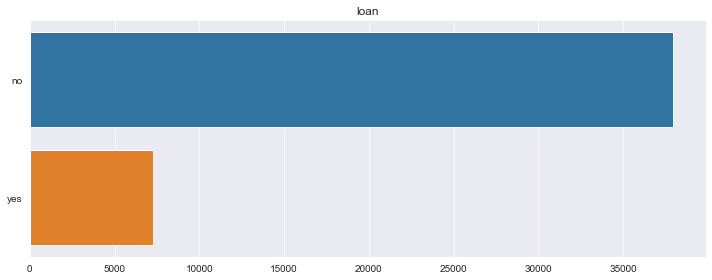

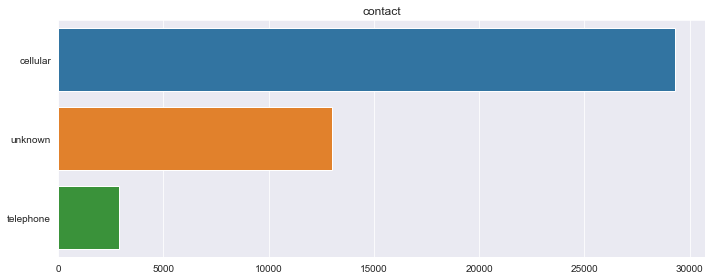

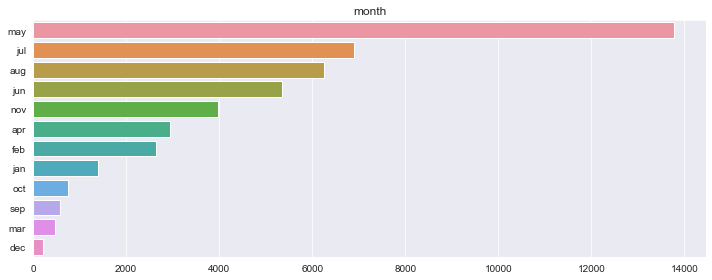

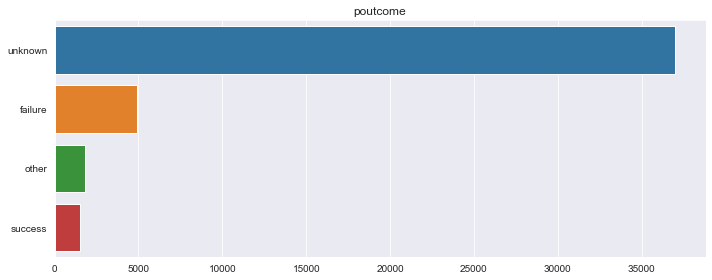

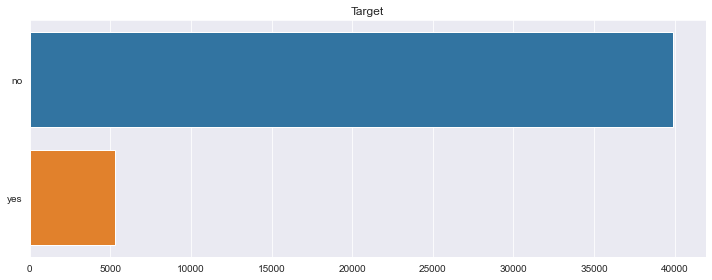

In [28]:
# create univariate plots for all categorical columns

for col in category_cols:
    plt.figure(figsize=(10,4))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

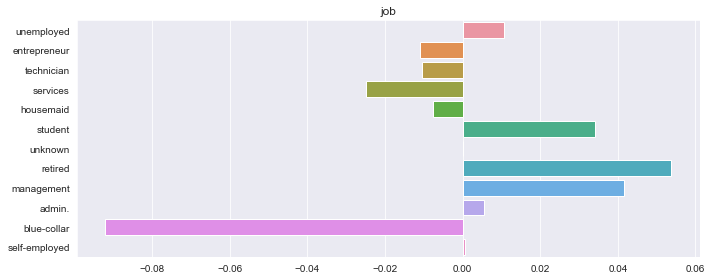

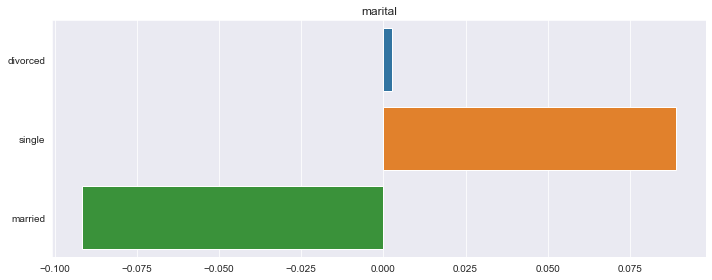

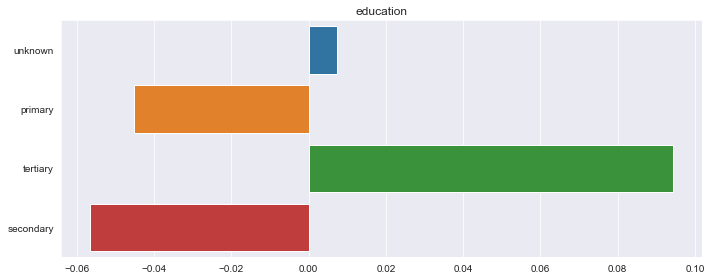

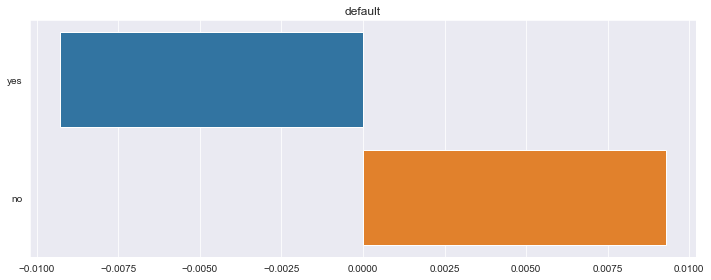

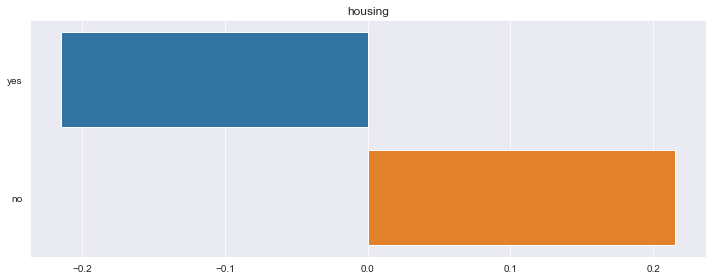

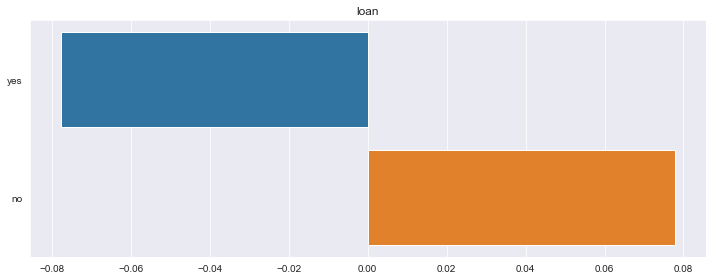

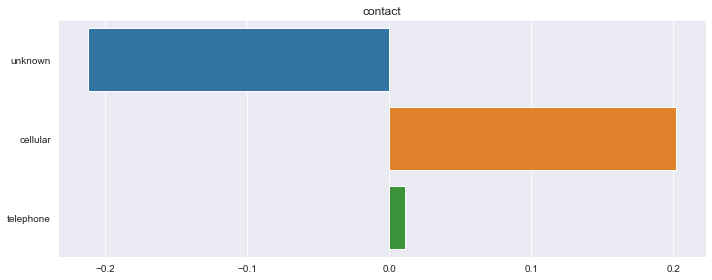

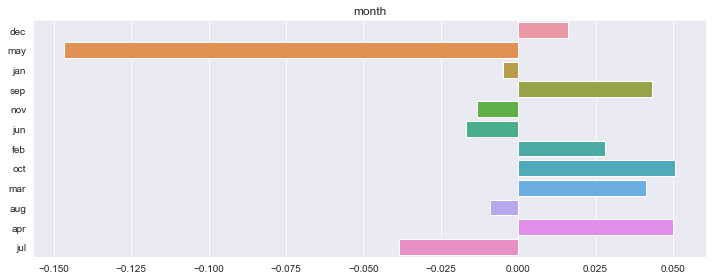

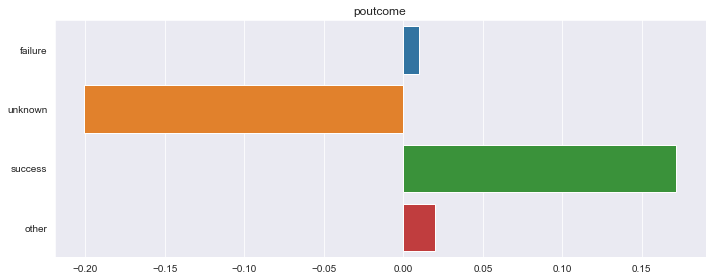

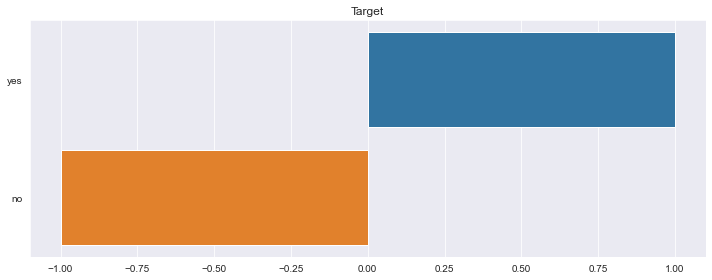

In [29]:
# creating multivariate plots for wrt. target columns

for col in category_cols:
    plt.figure(figsize=(10,4))
    #Returns counts of unique values for each outcome for each feature.
    pos_counts = df.loc[df.Target.values == 'yes', col].value_counts() 
    neg_counts = df.loc[df.Target.values == 'no', col].value_counts()
    
    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))
    
    #Counts of how often each outcome was recorded.
    freq_pos = (df.Target.values == 'yes').sum()
    freq_neg = (df.Target.values == 'no').sum()
    
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()
    
    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) / freq_pos - neg_counts.get(k, 0) / freq_neg for k in all_counts]

    sns.barplot(all_counts, all_index)
    plt.title(col)
    plt.tight_layout()
    

In [30]:
df['Target'].replace({'no':0,'yes':1},inplace=True)  

In [31]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


<AxesSubplot:>

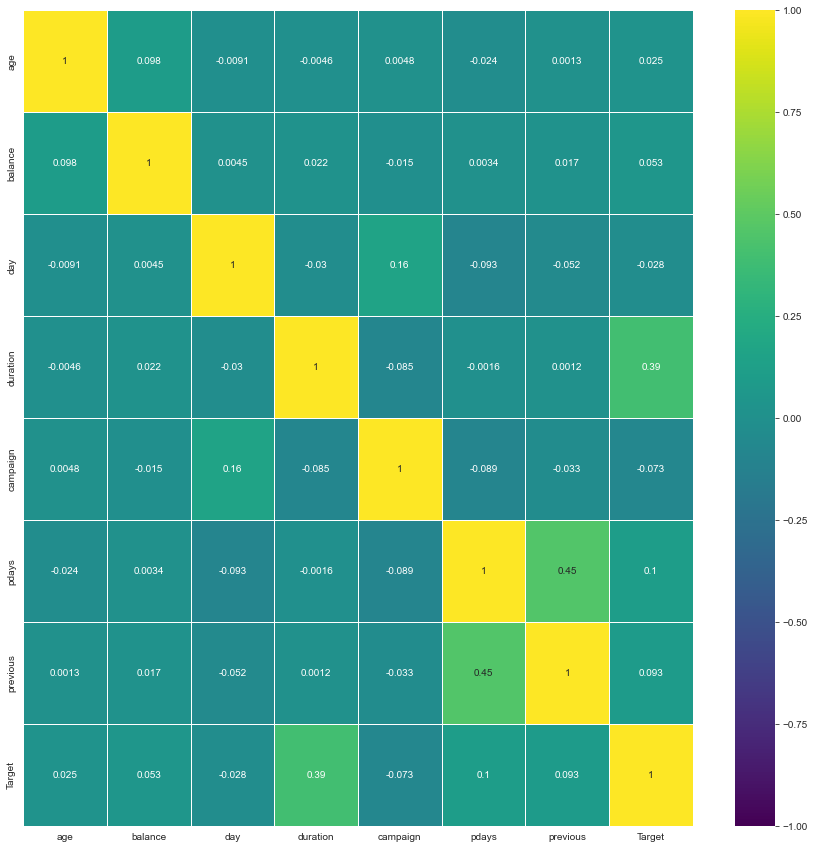

In [33]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(), annot=True,cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.5,ax=ax)

In [34]:
def boxplot(df,width=20,height=200):
    """
    Objective
    ----------
    Draw a box plot to show distributions, skiping all the object variables
    (adjust the width and height to get best possible result)
    
    parameters
    ----------
    df: pandas dataframe
        input data frame 
    width: int
        width for box plot
    height: int
        height for box plot
        
    returns
    ----------
    matplotlib Axes
    Returns the Axes object with the plot drawn onto it.   
    """
    
    
    cols = list(df.select_dtypes(["float64","int64"]).columns)
    fig, axs = plt.subplots(len(cols),figsize=(width,height))
    
    
    for i, col in enumerate(cols):
        sns.boxplot(df[col] , ax = axs[i])

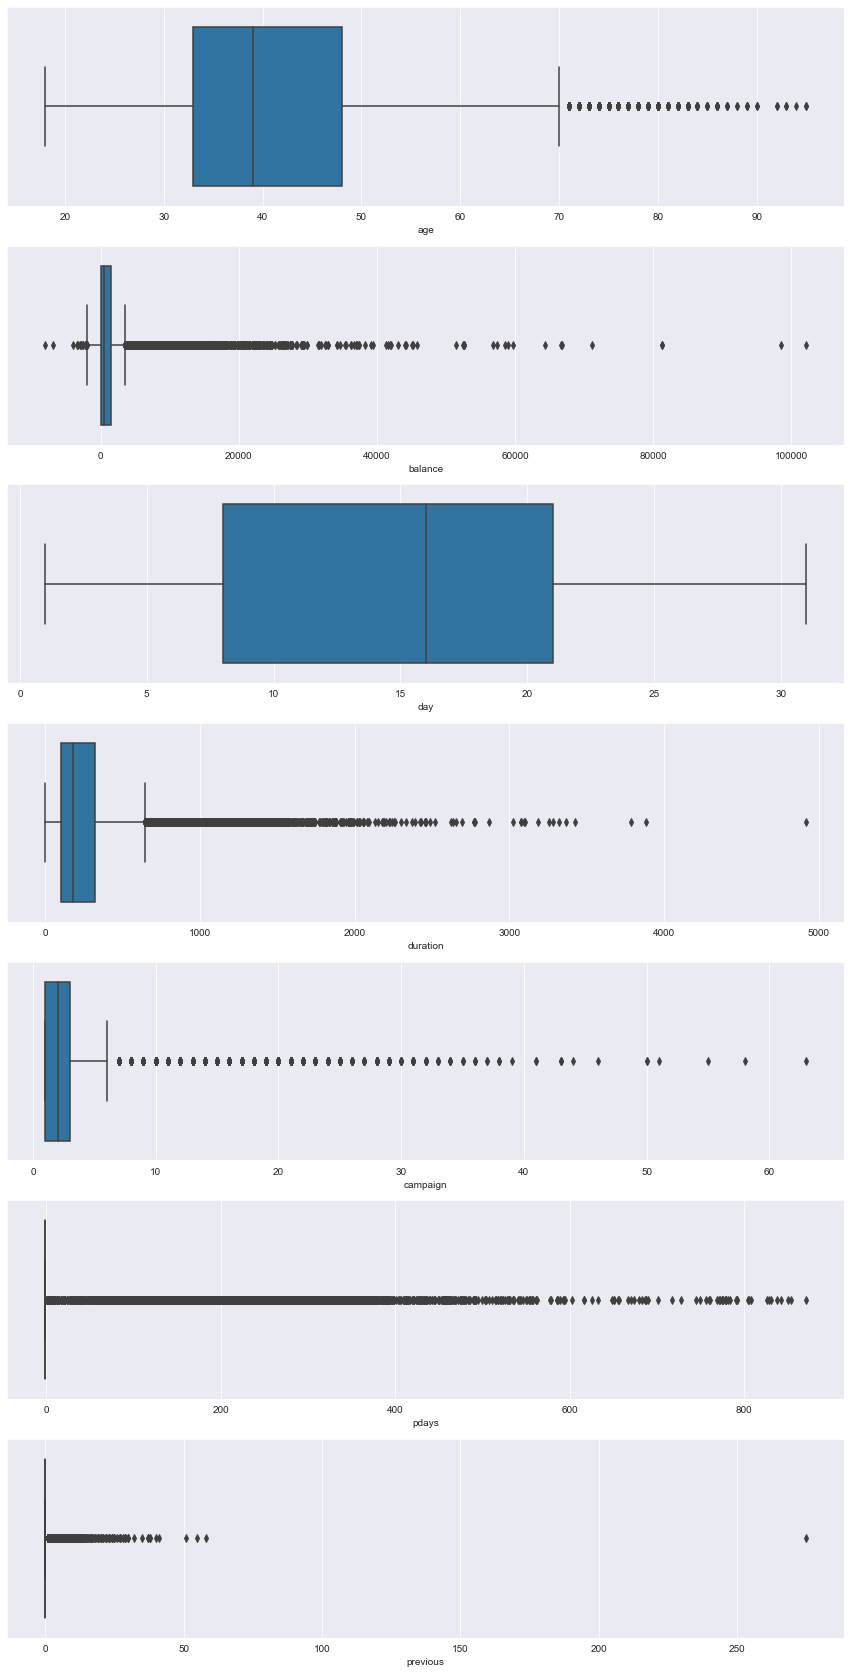

In [35]:
boxplot(df.iloc[:,:-1], width=15, height=30)

clusters of outlier present so we are not going to treat this, because by doing this we will manipulate our data 

In [36]:
df["duration"]/60

0         4.350000
1         2.516667
2         1.266667
3         1.533333
4         3.300000
           ...    
45206    16.283333
45207     7.600000
45208    18.783333
45209     8.466667
45210     6.016667
Name: duration, Length: 45211, dtype: float64

In [37]:
# convert duration of total secs to min
df['duration'] = df['duration'].apply(lambda n:n/60).round(2)

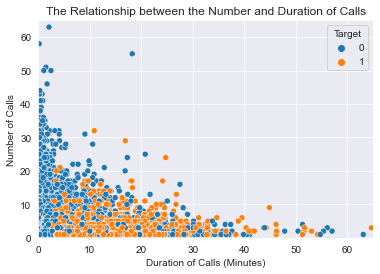

In [38]:
duration_campaign = sns.scatterplot(x='duration', y='campaign',data = df,
                     hue = 'Target')

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls')
# Annotation
plt.show()

In [39]:
# users where call duration is less than 10sec
less_dur = df[df.duration < 10/60]
less_dur["Target"].value_counts()

0    341
1      1
Name: Target, dtype: int64

In [40]:
# 341 users records where call duration is less than 10sec belong to 1
# droping 341
df = df.drop(df[df.duration < 10/60].index, axis = 0, inplace = False)

In [41]:
#putting age into bins
df.loc[df["age"] < 30,  'age'] = 20
df.loc[(df["age"] >= 30) & (df["age"] <= 39), 'age'] = 30
df.loc[(df["age"] >= 40) & (df["age"] <= 49), 'age'] = 40
df.loc[(df["age"] >= 50) & (df["age"] <= 59), 'age'] = 50
df.loc[df["age"] >= 60, 'age'] = 60

In [42]:
df = df.drop("default", axis=1) # droping default col (all no except 5 rows)
category_cols.remove("default")

## Function to generate model report and plot auc_roc curve

In [43]:
def generate_auc_roc_curve(clf, X_test, Y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.legend(loc=4)
    plt.show()
    pass

In [55]:
def generate_model_report(y_actual, y_predicted):
    print("---------------------Accuracy Score -----------------")
    print(accuracy_score(y_actual, y_predicted))
    print("-----------------  Confussion Matrix -----------------")
    print(confusion_matrix(y_actual, y_predicted))
    print("----------------Classification Report-----------------")
    print(classification_report(y_actual, y_predicted))
    pass

## Model Training

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [46]:
labelenc = LabelEncoder()
df[category_cols] = df[category_cols].apply(LabelEncoder().fit_transform)

In [47]:
df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,50,4,1,2,2143,1,0,2,5,8,4.35,1,-1,0,3,0
1,40,9,2,1,29,1,0,2,5,8,2.52,1,-1,0,3,0
2,30,2,1,1,2,1,1,2,5,8,1.27,1,-1,0,3,0
3,40,1,1,3,1506,1,0,2,5,8,1.53,1,-1,0,3,0
4,30,11,2,3,1,0,0,2,5,8,3.30,1,-1,0,3,0


In [48]:
X = df.drop(['Target','duration'],1)
y = df['Target']

We have dropped the 'duration' variable as the value of the variable will only be known at the end of the call. 
Hence, at that time we will also know the outcome of the call. 
The 'duration' variable will lead to leakage in the data and the prediction model will not be realistic.


In [50]:
X_train_im, X_test_im, y_train_im, y_test_im= train_test_split(X,y, test_size=0.3, random_state=0)

## Logistic Regression

In [51]:
lg_clf=LogisticRegression()

In [52]:
#Fitting on data
lg_clf.fit(X_train_im, y_train_im)

#Scoring the model on train data
score_lg_train=lg_clf.score(X_train_im, y_train_im)
print("Training score: %.2f " % score_lg_train)

#Scoring the model on test_data
score_lg_test=lg_clf.score(X_test_im, y_test_im)
print("Testing score: %.2f " % score_lg_test)

y_pred_lg = lg_clf.predict(X_test_im)
# y_prob = rf_clf.predict_proba(X_test)
# probs = y_prob[:,1]

Training score: 0.88 
Testing score: 0.88 


In [56]:
generate_model_report(y_test_im,y_pred_lg)

---------------------Accuracy Score -----------------
0.8788351534061363
-----------------  Confussion Matrix -----------------
[[11827     6]
 [ 1625     3]]
----------------Classification Report-----------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     11833
           1       0.33      0.00      0.00      1628

    accuracy                           0.88     13461
   macro avg       0.61      0.50      0.47     13461
weighted avg       0.81      0.88      0.82     13461



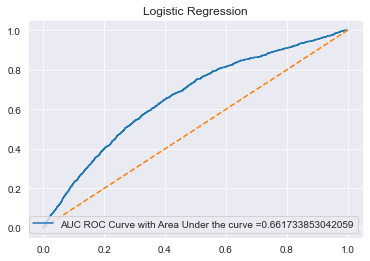

In [57]:
y_pred_proba = lg_clf.predict_proba(X_test_im)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test_im,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_im, y_pred_proba)
plt.title('Logistic Regression')
plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()


## Random Forest Classifier

In [58]:
#Initialising Random Forest model
rf_clf=RandomForestClassifier(n_estimators=100,n_jobs=100,random_state=0, min_samples_leaf=100)

#Fitting on data
rf_clf.fit(X_train_im, y_train_im)

#Scoring the model on train data
score_rf=rf_clf.score(X_train_im, y_train_im)
print("Training score: %.2f " % score_rf)

#Scoring the model on test_data
score_rf=rf_clf.score(X_test_im, y_test_im)
print("Testing score: %.2f " % score_rf)

y_pred_rf = rf_clf.predict(X_test_im)

Training score: 0.89 
Testing score: 0.89 


In [59]:
generate_model_report(y_test_im,y_pred_rf)

---------------------Accuracy Score -----------------
0.8899041675952752
-----------------  Confussion Matrix -----------------
[[11755    78]
 [ 1404   224]]
----------------Classification Report-----------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11833
           1       0.74      0.14      0.23      1628

    accuracy                           0.89     13461
   macro avg       0.82      0.57      0.59     13461
weighted avg       0.87      0.89      0.86     13461



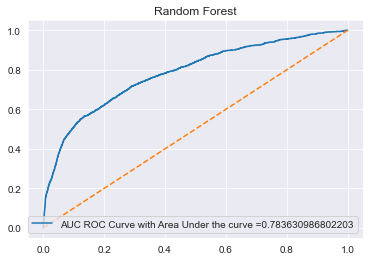

In [60]:
y_pred_proba = rf_clf.predict_proba(X_test_im)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test_im,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_im, y_pred_proba)
plt.title('Random Forest')
plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()

## Gradient Boosting 

In [61]:
#predicting using the 
from sklearn.ensemble import GradientBoostingClassifier
gb_clf =GradientBoostingClassifier(n_estimators=100,)

#Fitting on data
gb_clf.fit(X_train_im, y_train_im)

#Scoring the model on train data
score_gb = gb_clf.score(X_train_im, y_train_im)
print("Training score: %.2f " % score_gb)

#Scoring the model on test_data
score_gb=gb_clf.score(X_test_im, y_test_im)
print("Testing score: %.2f " % score_gb)

y_pred_gb = gb_clf.predict(X_test_im)

Training score: 0.90 
Testing score: 0.89 


In [62]:
generate_model_report(y_test_im,y_pred_gb)

---------------------Accuracy Score -----------------
0.890795631825273
-----------------  Confussion Matrix -----------------
[[11690   143]
 [ 1327   301]]
----------------Classification Report-----------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11833
           1       0.68      0.18      0.29      1628

    accuracy                           0.89     13461
   macro avg       0.79      0.59      0.62     13461
weighted avg       0.87      0.89      0.86     13461



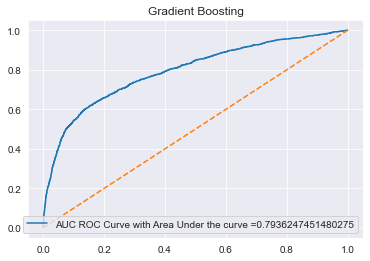

In [63]:
y_pred_proba = gb_clf.predict_proba(X_test_im)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test_im,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_im, y_pred_proba)
plt.title('Gradient Boosting')
plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()



# Random Forest with GridSearch

In [ ]:
#Parameter grid
parameter_grid = {'max_depth': np.arange(3,10), 'min_samples_leaf': range(10,50,10)}

# Code starts here
model_2 = RandomForestClassifier(n_estimators=30, random_state = 33)

p_tree = GridSearchCV(estimator=model_2,param_grid=parameter_grid,cv=5)

p_tree.fit(X_train_im,y_train_im)

acc_2 = p_tree.score(X_test_im,y_test_im)

y_pred_hyp = p_tree.predict(X_test_im)
print('Accuracy of Grid Seacrch cv = ',acc_2)
# Code ends here

In [ ]:
p_tree.best_params_

In [ ]:
generate_model_report(y_test_im,y_pred_hyp)

In [ ]:
y_pred_proba = p_tree.predict_proba(X_test_im)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test_im,  y_pred_proba)
auc = metrics.roc_auc_score(y_test_im, y_pred_proba)
plt.title('Random Forest with GridSearch')
plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()


# Undersampling

data set is highly imbalanced wo we will use undersampling technique to balance the data set target

In [64]:
minority_class_len = len(df[df.Target == 1])
print(minority_class_len)

5288


In [65]:
majority_class_indices = df[df['Target'] == 0].index
print(majority_class_indices)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            45181, 45183, 45184, 45186, 45189, 45194, 45198, 45199, 45209,
            45210],
           dtype='int64', length=39581)


In [66]:
random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_len, 
                                           replace=False)
print(len(random_majority_indices))

5288


In [67]:
minority_class_indices = df[df['Target'] == 1].index
print(minority_class_indices)

Int64Index([   83,    86,    87,   129,   168,   270,   388,   390,   446,
              457,
            ...
            45197, 45200, 45201, 45202, 45203, 45204, 45205, 45206, 45207,
            45208],
           dtype='int64', length=5288)


<AxesSubplot:xlabel='Target', ylabel='count'>

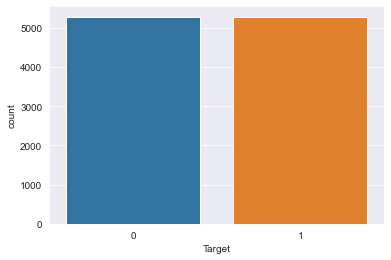

In [68]:
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])
under_sample = df.loc[under_sample_indices]
sns.countplot(x='Target', data=under_sample)

In [69]:
X_bl = under_sample.drop(['Target','duration'],1)
Y_bl = under_sample.loc[:, df.columns=='Target']
X_train_bl, X_test_bl, Y_train_bl, Y_test_bl = train_test_split(X_bl, Y_bl, test_size=0.33, random_state=42)

## RandomForestClassifier Balanced

In [70]:
rf_clf_bl = RandomForestClassifier().fit(X_train_bl, Y_train_bl)
Y_Test_Pred_rf = rf_clf_bl.predict(X_test_bl)

In [71]:
generate_model_report(Y_test_bl, Y_Test_Pred_rf)

---------------------Accuracy Score -----------------
0.7172729876826124
-----------------  Confussion Matrix -----------------
[[1325  388]
 [ 599 1179]]
----------------Classification Report-----------------
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      1713
           1       0.75      0.66      0.70      1778

    accuracy                           0.72      3491
   macro avg       0.72      0.72      0.72      3491
weighted avg       0.72      0.72      0.72      3491



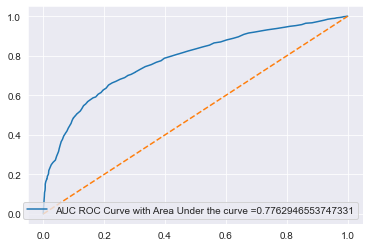

In [72]:
generate_auc_roc_curve(rf_clf_bl, X_test_bl, Y_test_bl)


## Logistic Regression Balanced

In [73]:
lg_clf_bl = LogisticRegression().fit(X_train_bl, Y_train_bl)
y_test_logistic_bl = lg_clf_bl.predict(X_test_bl)


In [74]:
generate_model_report(Y_test_bl, y_test_logistic_bl)

---------------------Accuracy Score -----------------
0.6490976797479232
-----------------  Confussion Matrix -----------------
[[1036  677]
 [ 548 1230]]
----------------Classification Report-----------------
              precision    recall  f1-score   support

           0       0.65      0.60      0.63      1713
           1       0.64      0.69      0.67      1778

    accuracy                           0.65      3491
   macro avg       0.65      0.65      0.65      3491
weighted avg       0.65      0.65      0.65      3491



In [ ]:
generate_auc_roc_curve(lg_clf_bl, X_test_bl,Y_test_bl)

## Gradient Boosting Blanced

In [75]:
gb_clf_bl = GradientBoostingClassifier(n_estimators=100,).fit(X_train_bl, Y_train_bl)
y_test_gradient_bl = gb_clf_bl.predict(X_test_bl)

In [76]:
generate_model_report(Y_test_bl, y_test_gradient_bl)

---------------------Accuracy Score -----------------
0.7232884560297909
-----------------  Confussion Matrix -----------------
[[1364  349]
 [ 617 1161]]
----------------Classification Report-----------------
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1713
           1       0.77      0.65      0.71      1778

    accuracy                           0.72      3491
   macro avg       0.73      0.72      0.72      3491
weighted avg       0.73      0.72      0.72      3491



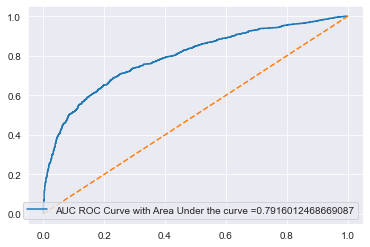

In [77]:
generate_auc_roc_curve(gb_clf_bl, X_test_bl,Y_test_bl)

## Model Comparision 

- we have implemented logistic regresssion, random forest, and gradient boosting algo.
- the data set is imbalanced so all three algo. poorly predicted the yes category of target variable.
- in logistic regression we got very poor performance, gradient boosting is better than logistic and random forest

- Data is imbalanced, so we use undersampling technique to balanced the dataset
- on balanced data set gradient boosting and random forest are able to predict the yes category of target varible, precision recall and f1 score also increses
